In [13]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, add_messages, END
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

In [14]:
load_dotenv()

True

In [21]:
llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")
search_tool = TavilySearch(max_results=4)

tools = [search_tool]

memory = MemorySaver()

In [22]:
llm_with_tools = llm.bind_tools(tools = tools)

In [37]:
from langchain_core.messages import HumanMessage, ToolMessage
class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state['messages'])
    return {
        "messages": [result]
    }

async def tools_router(state: State):
    last_message = state['messages'][-1]

    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END

    
async def tool_node(state: State):
    """Custom tool node that handles tool calls from LLM"""
    tool_calls = state["messages"][-1].tool_calls

    tool_messages = []

    # process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        print(tool_name, tool_args, tool_id)

        if tool_name == "tavily_search":
            search_results = await search_tool.ainvoke(tool_args)
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id = tool_id,
                name = tool_name
            )
            tool_messages.append(tool_message)
    
    return {
        "messages": tool_messages
    }

In [38]:
graph_builder = StateGraph(State)
graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_edge("tool_node", "model")
graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        END: END
    }
)

graph = graph_builder.compile(checkpointer=memory)

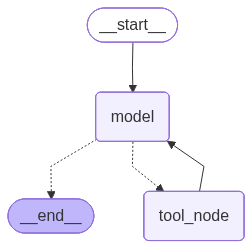

In [39]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [ ]:
thread_id = uuid4()

config = {
    "configurable": {
        "thread_id": thread_id
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="What's current weather in bangkok, thailand?")]
}, config=config)

tavily_search {'query': 'current weather in Bangkok, Thailand'} 5150dfa9-9931-4ff7-a976-a4aad68814ef


In [52]:
print(dict(response["messages"][-1])['content'][0]["text"])

The current weather in Bangkok, Thailand is partly cloudy with a temperature of 28.2°C (82.8°F), but it feels like 32.2°C (89.9°F). The humidity is 70%, and there is a wind of 9.0 kph from the Northeast.
